In [1]:
import pandas as pd
from tensorflow import keras
from keras import backend as K
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist
import numpy as np


2023-12-12 22:13:47.118499: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 22:13:47.170511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 22:13:47.170565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 22:13:47.171887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 22:13:47.179697: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 22:13:47.180238: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
num_classes = 10            # Number of classes in the Fashion MNIST dataset
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

In [3]:
# Get the data from the keras repository
mnist_data = fashion_mnist.load_data()

# x = images, y = labels
x = mnist_data[0][0]
y = mnist_data[0][1]

# Split data test(20%), train(70%), and validation(10%) sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=41)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=41)

In [4]:
print(len(x),len(x_train),len(x_test),len(x_val))

60000 42000 12000 6000


In [5]:
# Cast to a 32 bit float and then scale so the value is a float normalized between 0 and 1. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_test /= 255
x_val /= 255

# Saving copies of original data before reshaping
x_train_o = x_train
x_test_o = x_test
x_val_o = x_val
y_train_o = y_train
y_test_o = y_test
y_val_o = y_val

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)

# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [6]:
print(x_train.shape, y_train.shape)

(42000, 784) (42000, 10)


In [7]:
# Initialize the Random Forest model with the desired parameters
rf = RandomForestClassifier(n_estimators=100, random_state=41)

# Train the model using the training data
rf.fit(x_train, y_train)

# Predict the output for the testing set
y_pred = rf.predict(x_val)
y_pred_prob = rf.predict_proba(x_val)

In [8]:
yp = np.argmax(y_pred, axis=-1)
y = np.argmax(y_val, axis=-1)
ypp = np.zeros(len(yp))
for i in range(len(yp)):
    ypp[i] = np.max(y_pred_prob[yp[i]][i], axis=-1)

In [9]:
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
accuracy = accuracy_score(y, yp)

print(f'RF Accuracy: {accuracy:.2f}')
print('RF Precision (True Positive / True Positive+False Positive):', precision)
print('RF Recall (True Positive / True Positive+False Negative):', recall)
print('RF F1 Score (2 * Precision*Recall / Precision+Recall):', (2 * ((precision*recall) / (precision+recall))))

RF Accuracy: 0.82
RF Precision (True Positive / True Positive+False Positive): 0.9309413547755834
RF Recall (True Positive / True Positive+False Negative): 0.8003333333333333
RF F1 Score (2 * Precision*Recall / Precision+Recall): 0.8607107846291333


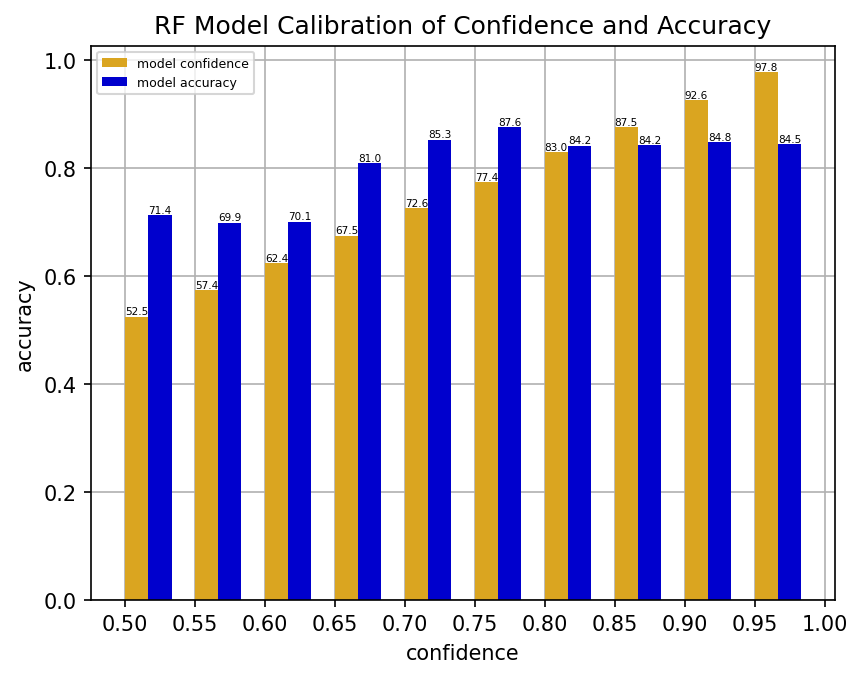

In [10]:
def reliability_stats(y, y_pred, y_pred_prob, n_bins, n_classes):
    y_hat = np.argmax(y_pred, axis=-1)
    y_conf = np.zeros(len(y_hat))
    for i in range(len(y_hat)):
        y_conf[i] = np.max(y_pred_prob[y_hat[i]][i], axis=-1)
    
    n_samples = len(y)
   
    bin_conf = []
    bin_acc = []
    bin_count = []
    bin_edges = np.linspace(1/2, 1, n_bins+1)
    ece_sum = 0
    for i in range(n_bins):
        idx = np.argwhere(np.logical_and(bin_edges[i] < y_conf, y_conf < bin_edges[i+1]))
        
        if len(idx) == 0:
            bin_conf.append(0)
            bin_acc.append(0)
            bin_count.append(0)
            continue
        
        bc = np.mean(y_conf[idx])
        ba = np.mean(y[idx] == y_hat[idx])
        bn = len(idx)
        
        bin_conf.append(bc)
        bin_acc.append(ba)
        bin_count.append(bn)
        ece_sum += bn * np.abs(bc-ba)
    
    ece = ece_sum / n_samples
    
    return {
        'bin_edges': np.array(bin_edges),
        'bin_conf': np.array(bin_conf),
        'bin_acc': np.array(bin_acc),
        'bin_count': np.array(bin_count),
        'ece': ece
    }

def plot_reliability_diagram(y, ypred, y_pred_prob, n_bins, n_classes):
    plt.rcParams['figure.dpi'] = 150
    stats = reliability_stats(y, y_pred, y_pred_prob, n_bins, n_classes)
    bin_conf = stats['bin_conf']
    bin_acc = stats['bin_acc']
    bin_edges = stats['bin_edges']
    ece = stats['ece']
    
    bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2
    bin_width = np.diff(bin_edges)/3
    
    label_conf = [str(round(val * 100, 1)) for val in bin_conf]
    label_acc = [str(round(val * 100, 1)) for val in bin_acc]
    
    fig, ax = plt.subplots()
    p1 = ax.bar(x=bin_edges[:-1]+bin_width/2, height=bin_conf, width=bin_width, color='goldenrod')
    ax.bar_label(p1, labels=label_conf, fontsize=5)
    p2 = ax.bar(x=bin_edges[:-1]+3*bin_width/2, height=bin_acc, width=bin_width, color='mediumblue')
    ax.bar_label(p2, labels=label_acc, fontsize=5)
    plt.grid()
    ax.set_axisbelow(True)
    plt.xticks(bin_edges)
    plt.ylabel('accuracy')
    plt.xlabel('confidence')
    plt.legend(['model confidence', 'model accuracy'], prop={'size': 6})
    plt.title('RF Model Calibration of Confidence and Accuracy')
    plt.show()

plot_reliability_diagram(y, y_pred, y_pred_prob, n_bins=10, n_classes=10)  

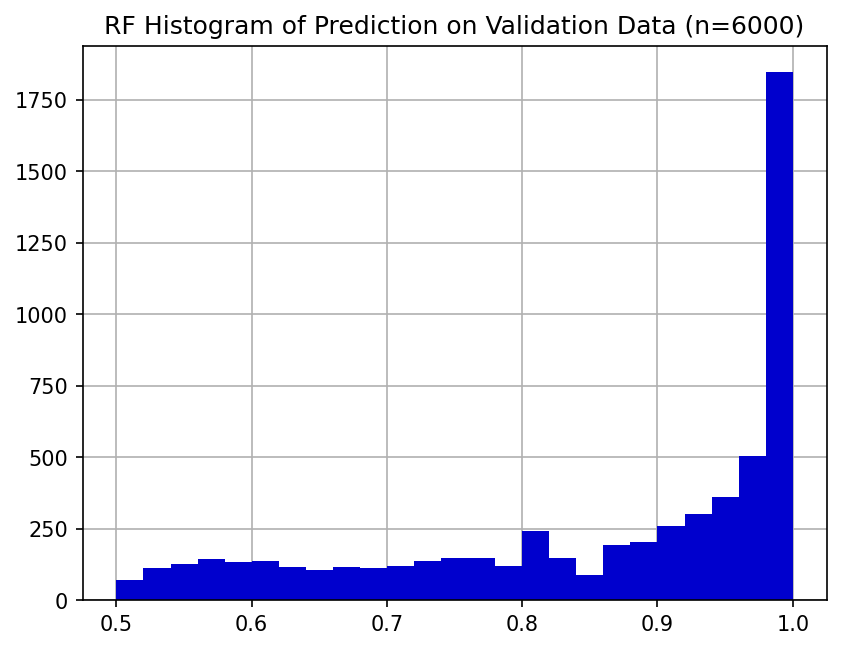

In [11]:
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
plt.title(f"RF Histogram of Prediction on Validation Data (n={len(ypp)})")
ax.set_axisbelow(True)
plt.grid()
plt.hist(ypp, 25, density=False, color='mediumblue')
plt.show()

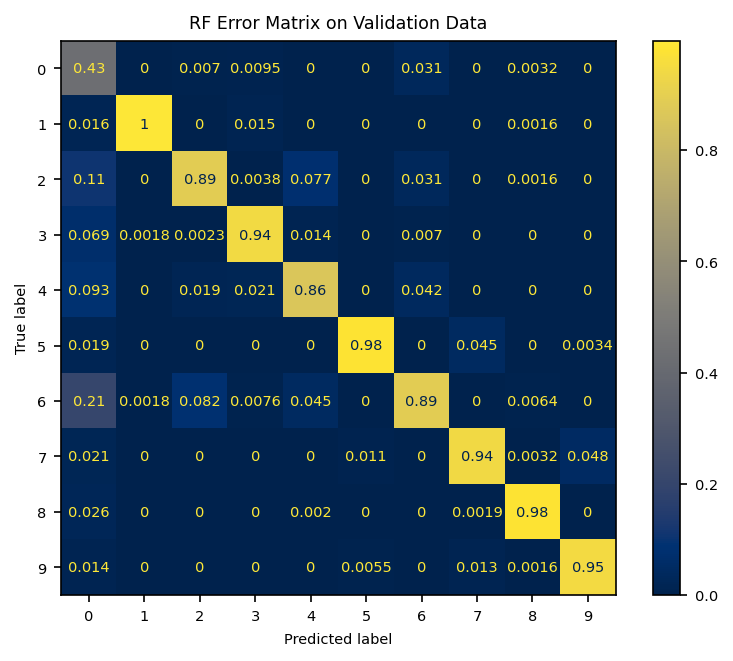

In [12]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({'font.size': 7})
cm = confusion_matrix(y, yp, normalize='pred', labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='cividis')
plt.title("RF Error Matrix on Validation Data")
plt.show()

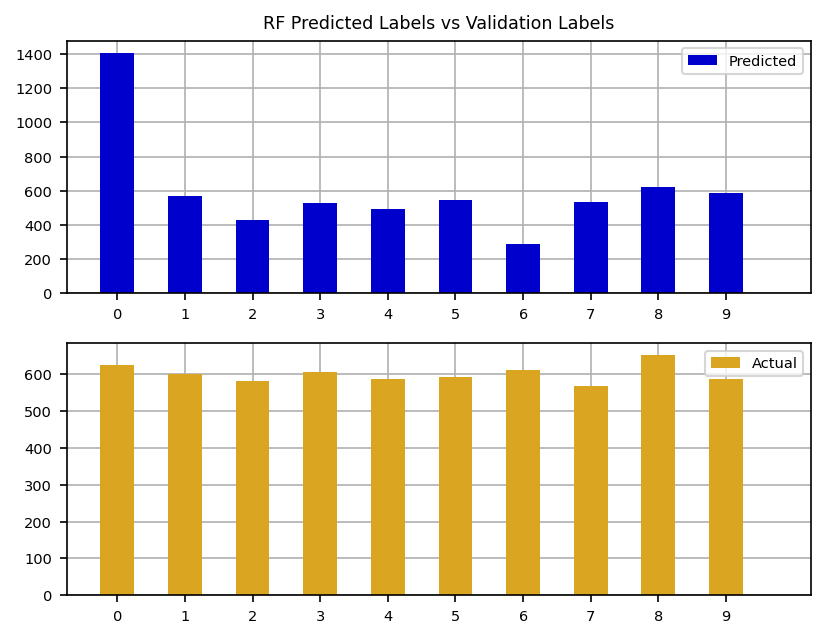

In [13]:
plt.rcParams['figure.dpi'] = 150
ax1 = plt.subplot(211)
#plt.hist(np.argmax(y_pred, axis=-1), 24, range=[-0.5, 9.5], align='mid', density=False, color='mediumblue')
plt.hist(yp, width=.5, bins=np.arange(11)-0.25, density=False, color='mediumblue')
plt.grid()
ax1.set_axisbelow(True)
plt.legend(['Predicted'])
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.title('RF Predicted Labels vs Validation Labels')
ax2 = plt.subplot(212)
plt.hist(y, width=.5, bins=np.arange(11)-0.25, density=False, color='goldenrod')
plt.grid()
ax2.set_axisbelow(True)
plt.legend(['Actual'])
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.show()

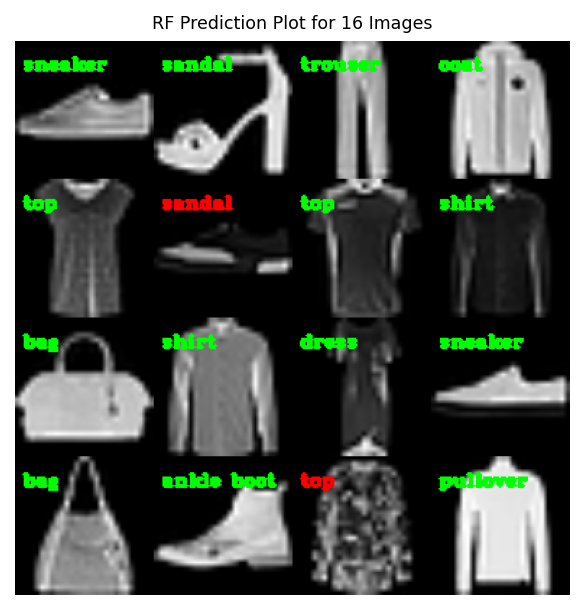

In [14]:
import cv2
from imutils import build_montages
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize list of output images
images = []

# Define labels in correct order
labelNames = ["top", "trouser", "pullover", "dress", "coat",
              "sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# Randomly select testing fashion items
for i in np.random.choice(np.arange(0, len(y_val)), size=(16,)):
    # Classify the clothing
    probs = rf.predict(x_val[np.newaxis, i])
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]
    
    # Extract the image from the testData if using "channels_first" ordering
    if K.image_data_format() == "channels_first":
        image = (x_val_o[i][0] * 255).astype("uint8")
    # Else use "channels_last" ordering
    else:
        image = (x_val_o[i] * 255).astype("uint8")

    # Initialize the text label color as green (correct)
    color = (0, 255, 0)
    
    # Otherwise, the class label prediction is red (incorrect) 
    if prediction[0] != np.argmax(y_val[i]):
        color = (255, 0, 0)
    
    # Merge the channels into one image and resize the image from 28x28 to 96x96
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    
    # Draw the predicted label on the image
    cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.60, color, 2)
    
    # Add the image to list of output images
    images.append(image)
    
# Construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]

# Show the output montage
plt.imshow(montage)
plt.axis('off')
plt.title(f"RF Prediction Plot for 16 Images")
plt.show()